1. minimal data setup
(note: my data cleaning is nonexistent, so Jiatong's preprocessing will be different and results will differ — nevertheless, the format is what matters here)

In [5]:
from COS597.data_util import load_data, get_dataloader, prepare_data
from datasets import load_dataset
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pickle

In [6]:
# CHANGE ME
DEBUG = True
SEED = 123

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [7]:
# logging boilerplate
# import logging
# handlers = [logging.StreamHandler()]
# logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
#                     datefmt='%m/%d/%Y %H:%M:%S',
#                     level=logging.INFO,
#                     handlers=handlers)
# logger = logging.getLogger(__name__)

# # load data
# raw_data = load_data(logger, name='newsroom', split='train', data_dir='/n/fs/nlp-mwtang/onthefly/data')
# if DEBUG:
#     data = raw_data.select([i for i in range(200)])
# else:
#     data = raw_data

In [8]:
# n_sample = 3000
# newsroom_raw_data = raw_data
# newsroom_data = newsroom_raw_data.select([random.randint(0,len(raw_data)-1) for i in range(n_sample)])

In [9]:
# load data
raw_data = load_dataset('cc_news', split='train')
if DEBUG:
    data = raw_data.select([i for i in range(200)])
else:
    data = raw_data

Reusing dataset cc_news (/u/mwtang/.cache/huggingface/datasets/cc_news/plain_text/1.0.0/ae469e556251e6e7e20a789f93803c7de19d0c4311b6854ab072fecb4e401bd6)


In [10]:
# CHANGE ME
n_sample = 1000
cc_raw_data = raw_data
cc_data = cc_raw_data.select([random.randint(0,len(raw_data)-1) for i in range(n_sample)])

In [11]:
# cc_data = cc_raw_data

2. sparse retriever: bm25

In [12]:
from rank_bm25 import BM25Okapi

corpus = [x['text'] for x in cc_data]
tokenized_corpus = [re.split(' |\n', doc) for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

In [13]:
query = cc_raw_data[130]['title']
tokenized_query = re.split(' |\n', query)
neighbors = bm25.get_top_n(tokenized_query, range(len(corpus)), n=30)
scores = bm25.get_scores(tokenized_query)

In [14]:
# todo filter out "Read the rest of the story"

In [17]:
with open('bm25_cc_news_text_re_1000.pickle', 'wb') as f:
    pickle.dump([bm25, tokenized_corpus, corpus], f, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
# with open('bm25_cc_news_text_re_1000.pickle', 'rb') as f:
#     bm25, tokenized_corpus, corpus = pickle.load(f)

In [19]:
query

'Man accused in Crookston bar death a free man'

In [25]:
cc_data[neighbors]['title']

['Man arrested in stabbings that killed his dad, hurt his mom',
 'Authorities: Missing man found dead in Lake Michigan',
 'Man mentally unfit for criminal trial released on bail as court hears no bed in Central Mental Hospital',
 'Judge orders new sentence for "Xbox murders" ringleader',
 'Man shot by Mankato police was school teacher, MSU grad',
 'Man convicted of 1st-degree murder in drug-deal robbery case',
 'Bond revoked for 29-year-old suspect in Nashville Waffle House attack',
 'Deadliest mass slayings in recent Canadian history',
 'Correction: Florida Execution story',
 "The Toronto van attack suspect warned of an 'incel rebellion' on Facebook hours before the attack",
 'An Emerald Along the Beach - Rosewood Phuket',
 'Montana prosecutor pleads no contest to resisting arrest',
 'Man sentenced to three years in prison for cannabis operation',
 'Tyranny from the Mormon Pulpit',
 'Huge celebrity Halloween party to rock the Midlands',
 'Minnesota woman suspected in 2 killings waives

In [21]:
scores[neighbors]

array([16.92366482, 16.63681469, 16.62514485, 16.50563503, 16.21836001,
       16.1498302 , 14.97047244, 14.83685015, 14.43578494, 13.79442633,
       13.69480622, 13.02718944, 13.00310158, 12.85976005, 12.60162008,
       12.55691045, 12.41384678, 12.28042735, 12.26060183, 12.18920458,
       11.88074116, 11.71482156, 11.69500397, 11.68911605, 11.56350114,
       11.50318066, 11.47915536, 11.46783786, 11.44471372, 11.43391611])

In [22]:
# dedup
seen_titles = set()
dedup_neighbors = []
for i in neighbors:
    if cc_data[i]['title'] not in seen_titles:
        dedup_neighbors.append(i)
        seen_titles.add(cc_data[i]['title'])
print('{} -> {}'.format(len(neighbors), len(dedup_neighbors)))

30 -> 30


In [23]:
cc_data[dedup_neighbors]

{'title': ['Man arrested in stabbings that killed his dad, hurt his mom',
  'Authorities: Missing man found dead in Lake Michigan',
  'Man mentally unfit for criminal trial released on bail as court hears no bed in Central Mental Hospital',
  'Judge orders new sentence for "Xbox murders" ringleader',
  'Man shot by Mankato police was school teacher, MSU grad',
  'Man convicted of 1st-degree murder in drug-deal robbery case',
  'Bond revoked for 29-year-old suspect in Nashville Waffle House attack',
  'Deadliest mass slayings in recent Canadian history',
  'Correction: Florida Execution story',
  "The Toronto van attack suspect warned of an 'incel rebellion' on Facebook hours before the attack",
  'An Emerald Along the Beach - Rosewood Phuket',
  'Montana prosecutor pleads no contest to resisting arrest',
  'Man sentenced to three years in prison for cannabis operation',
  'Tyranny from the Mormon Pulpit',
  'Huge celebrity Halloween party to rock the Midlands',
  'Minnesota woman suspe

In [24]:
scores[dedup_neighbors]

array([16.92366482, 16.63681469, 16.62514485, 16.50563503, 16.21836001,
       16.1498302 , 14.97047244, 14.83685015, 14.43578494, 13.79442633,
       13.69480622, 13.02718944, 13.00310158, 12.85976005, 12.60162008,
       12.55691045, 12.41384678, 12.28042735, 12.26060183, 12.18920458,
       11.88074116, 11.71482156, 11.69500397, 11.68911605, 11.56350114,
       11.50318066, 11.47915536, 11.46783786, 11.44471372, 11.43391611])

3. dense retriever: SimCSE (FAIL: somehow no attempt at installing has succeeded)

In [121]:
!pip install simcse

In [131]:
# from simcse import SimCSE
model = SimCSE("princeton-nlp/sup-simcse-bert-base-uncased")

OSError: Can't load config for 'princeton-nlp/unsup-simcse-bert-base-uncased'. Make sure that:

- 'princeton-nlp/unsup-simcse-bert-base-uncased' is a correct model identifier listed on 'https://huggingface.co/models'

- or 'princeton-nlp/unsup-simcse-bert-base-uncased' is the correct path to a directory containing a config.json file



In [ ]:
model.build_index(sentences)
results = model.search("He plays guitar.")

In [ ]:
embeddings = model.encode("A woman is reading.")

In [ ]:
# prepare data
tokenizer = 
input_tensors = prepare_data(logger, tokenizer,
                             data,
                             title_prefix= "Title:",
                             content_prefix= "Content:", 
                             max_length=args.input_max_len
                             )

4. PPLM with on-the-fly discriminator via retrieved reference documents

In [102]:
# CHANGE ME
idx = 130
query = cc_raw_data[idx]['title']
actual_text = cc_raw_data[idx]['text']
print(query)
n_pos_refs = 3
n_neg_refs = 2 * n_pos_refs # actually will just use enough to match the pos refs, so we provide more here
n_sents = 1

Man accused in Crookston bar death a free man


In [103]:
tokenized_query = re.split(' |\n', query)
neighbors = bm25.get_top_n(tokenized_query, range(len(corpus)), n=2*n_pos_refs)
# scores = bm25.get_scores(tokenized_query)

# dedup
seen_titles = set()
dedup_neighbors = []
for i in neighbors:
    if cc_data[i]['title'] not in seen_titles:
        dedup_neighbors.append(i)
        seen_titles.add(cc_data[i]['title'])
print('{} -> {}'.format(len(neighbors), len(dedup_neighbors)))

pos_refs = cc_data[dedup_neighbors[:n_pos_refs]]['text']

neg_refs = cc_data.select([random.randint(0,len(cc_data)-1) for i in range(n_neg_refs)])
neg_refs = [x['text'] for x in neg_refs]

6 -> 6


In [104]:
import nltk
# nltk.download('punkt')
import nltk.data

In [105]:
# CHANGE ME
ref_epochs = 10
ref_batch_size = 8
ref_lr = 0.001 # learning rate
pretrained_model = 'gpt2-medium'
cached = False
no_cuda = False
save_model = False
log_interval = 10
n_sents = 1

In [106]:
import argparse
import csv
import json
import math
import numpy as np
import os
import time
import torch
import torch.nn.functional as F
import torch.optim
import torch.optim as optim
import torch.utils.data as data
from nltk.tokenize.treebank import TreebankWordDetokenizer
from torchtext import data as torchtext_data
from torchtext import datasets
from tqdm import tqdm, trange
from transformers import BertTokenizer, BertModel
from transformers import GPT2Tokenizer, GPT2LMHeadModel

import PPLM
from PPLM.pplm_classification_head import ClassificationHead
from PPLM.run_pplm_discrim_train import *
from PPLM.run_pplm import *
import time

EPSILON = 1e-10
max_length_seq = 100

In [107]:
device = "cuda" if torch.cuda.is_available() and not no_cuda else "cpu"
add_eos_token = pretrained_model.startswith("gpt2")
    
idx2class = ["general", "in_topic"]
class2idx = {c: i for i, c in enumerate(idx2class)}

In [285]:
discriminator = Discriminator(
    class_size=len(idx2class),
    pretrained_model=pretrained_model,
    cached_mode=cached,
    device=device
).to(device)

discriminator_meta = {
    "class_size": len(idx2class),
    "embed_size": discriminator.embed_size,
    "pretrained_model": pretrained_model,
    "class_vocab": class2idx,
    "default_class": 0,
}

In [108]:
sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [109]:
# turn docs into a list of triples (or groups of n_sents) of sentences in those docs
def get_sent_groups(refs):
    ref_X = []
    for x in refs:
        sents = sent_tokenizer.tokenize(x)
        sent_groups = [' '.join(sents[i:i+n_sents]) for i in range(0, len(sents), n_sents)]
        ref_X.extend(sent_groups)
    return ref_X

def create_dataset(pos_refs, neg_refs):
    # turn positive and negative docs into a single list of groups of sentences
    ref_X_pos = get_sent_groups(pos_refs)
    ref_X_neg = get_sent_groups(neg_refs)
    ref_X = ref_X_pos + ref_X_neg
    ref_y = [1] * len(ref_X_pos) + [0] * len(ref_X_neg)
    n_pos = len(ref_X_pos)
    
    # TODO remove this flakiness
    assert len(ref_X) >= 2*n_pos
        
    ref_X = ref_X[:2*n_pos] # balance pos and neg
    ref_y = ref_y[:2*n_pos] # balance pos and neg

    # randomize
    perm = np.random.permutation(len(ref_X))
    ref_X = np.array(ref_X)[perm]
    ref_y = np.array(ref_y)[perm]

    # convert dataset to tensors
    n_examples = len(ref_X)
    ref_X_tensor = []
    ref_y_tensor = []
    for i in range(len(ref_X)):
        seq = discriminator.tokenizer.encode(ref_X[i])
        if len(seq) >= max_length_seq:
            print("Line {} is longer than maximum length {}, as it has length {}, truncating".format(
                i, max_length_seq, len(seq)
            ))
            seq = seq[:max_length_seq]
        if add_eos_token:
            seq = [50256] + seq
        seq = torch.tensor(
            seq, device=device, dtype=torch.long
        )
    #     else:
    #         print("Line {} is longer than maximum length {}".format(
    #             i, max_length_seq
    #         ))
    #         continue
        ref_X_tensor.append(seq)
        ref_y_tensor.append(ref_y[i])

    n_examples = len(ref_X_tensor) # may be less than before
    print('final number of examples =', n_examples)
    
    return Dataset(ref_X_tensor, ref_y_tensor)

In [110]:
test_pos_refs = [actual_text]
test_neg_refs = cc_data.select([random.randint(0,len(cc_data)-1) for i in range(n_neg_refs)])
test_neg_refs = [x['text'] for x in test_neg_refs]

def get_dataloaders(batch_size=ref_batch_size):    
    train_dataset = create_dataset(pos_refs, neg_refs)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           collate_fn=collate_fn)

    test_dataset = create_dataset(test_pos_refs, test_neg_refs)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              collate_fn=collate_fn)
    return train_loader, test_loader

In [111]:
def train_discrim(discrim, train_loader, test_loader, lr=ref_lr, epochs=ref_epochs):
    start = time.time()
    optimizer = optim.Adam(discrim.parameters(), lr=lr)
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch", epoch + 1)

        train_epoch(
            discriminator=discrim,
            data_loader=train_loader,
            optimizer=optimizer,
            epoch=epoch,
            log_interval=log_interval,
            device=device
        )
        test_loss, test_accuracy = evaluate_performance(
            data_loader=test_loader,
            discriminator=discrim,
            device=device
        )

        end = time.time()
        print("Epoch took: {:.3f}s".format(end - start))

        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print("\nExample prediction")
        predict(example_sentence, discrim, idx2class,
                cached=cached, device=device)

    #     if save_model:
    #         # torch.save(discriminator.state_dict(),
    #         #           "{}_discriminator_{}.pt".format(
    #         #               args.dataset, epoch + 1
    #         #               ))
    #         torch.save(discriminator.get_classifier().state_dict(),
    #                    classifier_head_fp_pattern.format(epoch + 1))

    min_loss = float("inf")
    min_loss_epoch = 0
    max_acc = 0.0
    max_acc_epoch = 0
    print("Test performance per epoch")
    print("epoch\tloss\tacc")
    for e, (loss, acc) in enumerate(zip(test_losses, test_accuracies)):
        print("{}\t{}\t{}".format(e + 1, loss, acc))
        if loss < min_loss:
            min_loss = loss
            min_loss_epoch = e + 1
        if acc > max_acc:
            max_acc = acc
            max_acc_epoch = e + 1
    print("Min loss: {} - Epoch: {}".format(min_loss, min_loss_epoch))
    print("Max acc: {} - Epoch: {}".format(max_acc, max_acc_epoch))

In [112]:
def reset_weights(discrim):
    discrim.get_classifier().mlp.reset_parameters()

In [113]:
test_pos_sents = get_sent_groups(test_pos_refs)
test_neg_sents = get_sent_groups(test_neg_refs)

def eval_discrim(discrim):
    print('discriminator predictions for ground truth:')
    for x in test_pos_sents:
        print(x)
        print(discrim.predict(x))

    print('discriminator predictions for random:')
    for x in test_neg_sents:
        print(x)
        print(discrim.predict(x))

In [37]:
# CHANGE ME (AGAIN, for easy tuning)
ref_epochs = 20
ref_batch_size = 8
ref_lr = 0.001 # learning rate

In [293]:
train_loader, test_loader = get_dataloaders(batch_size=ref_batch_size)
reset_weights(discriminator)
train_discrim(discriminator, train_loader, test_loader, lr=ref_lr, epochs=ref_epochs)

Line 5 is longer than maximum length 100, as it has length 219, truncating
Line 158 is longer than maximum length 100, as it has length 101, truncating
Line 168 is longer than maximum length 100, as it has length 173, truncating
Line 377 is longer than maximum length 100, as it has length 123, truncating
final number of examples = 394
Line 4 is longer than maximum length 100, as it has length 113, truncating
final number of examples = 40

Epoch 1
Train Epoch: 1 [8/394 (2%)]	Loss: 1.506125
Train Epoch: 1 [88/394 (22%)]	Loss: 0.906020
Train Epoch: 1 [168/394 (43%)]	Loss: 0.357469
Train Epoch: 1 [248/394 (63%)]	Loss: 0.346047
Train Epoch: 1 [328/394 (83%)]	Loss: 0.445938
Performance on test set: Average loss: 0.5342, Accuracy: 30/40 (75%)
Epoch took: 2.164s

Example prediction
Input sentence: This is incredible! I love it, this is the best chicken I have ever had.
Predictions: general: 0.8446, in_topic: 0.1554

Epoch 2
Train Epoch: 2 [8/394 (2%)]	Loss: 0.534661
Train Epoch: 2 [88/394 (22%

Train Epoch: 17 [88/394 (22%)]	Loss: 0.044117
Train Epoch: 17 [168/394 (43%)]	Loss: 0.055663
Train Epoch: 17 [248/394 (63%)]	Loss: 0.025383
Train Epoch: 17 [328/394 (83%)]	Loss: 0.047391
Performance on test set: Average loss: 0.8407, Accuracy: 25/40 (62%)
Epoch took: 2.220s

Example prediction
Input sentence: This is incredible! I love it, this is the best chicken I have ever had.
Predictions: general: 0.6259, in_topic: 0.3741

Epoch 18
Train Epoch: 18 [8/394 (2%)]	Loss: 0.074836
Train Epoch: 18 [88/394 (22%)]	Loss: 0.022014
Train Epoch: 18 [168/394 (43%)]	Loss: 0.068640
Train Epoch: 18 [248/394 (63%)]	Loss: 0.055378
Train Epoch: 18 [328/394 (83%)]	Loss: 0.005948
Performance on test set: Average loss: 0.6616, Accuracy: 30/40 (75%)
Epoch took: 2.231s

Example prediction
Input sentence: This is incredible! I love it, this is the best chicken I have ever had.
Predictions: general: 0.7852, in_topic: 0.2148

Epoch 19
Train Epoch: 19 [8/394 (2%)]	Loss: 0.013919
Train Epoch: 19 [88/394 (22%)]

In [184]:
train_loss = [1.5061, .906, .357, .346, .4459, .534, .196, .259, .174, .316, .203, .227]
test_loss = [0.7342, 0.5286, 0.6452, 0.5407, 0.7426, 0.6783, 0.5313, 0.5010, 0.5385, 0.5431, 0.5463, 0.5145]
# test_loss = [0.75, 0.75, 0.55, 0.775, 0.55, 0.625, 0.75, 0.85, 0.85, 0.75, 0.92, 0.85]

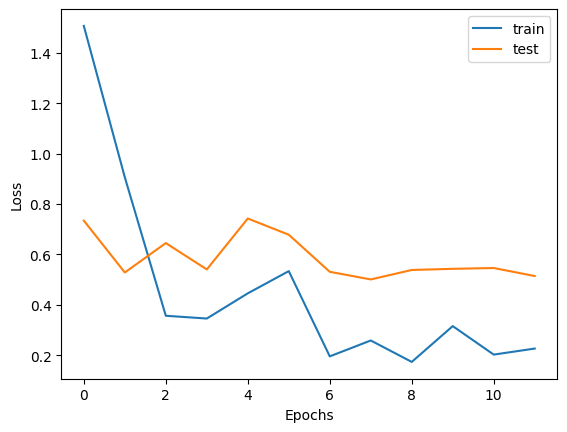

In [189]:
plt.plot(range(12), train_loss, label='train')
plt.plot(range(12), test_loss, label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [249]:
eval_discrim(discriminator)

discriminator predictions for ground truth:
The criminal case against the 29-year-old Crookston man officially was closed Tuesday after Judge Tamara Yon sentenced him in Polk County District Court for his actions during a confrontation with John Henry Torres, who died after hitting his head Dec. 25, 2015, outside Captain Crooks bar. Prosecutors failed to convince a jury that a shove from Strommen caused Torres' death.
[0.06414198229586979, 0.9358579906458565]
Strommen didn't deny pushing Torres, but he said he never saw Torres fall, suggesting the victim slipped on the ice. Torres died a week later at Altru Hospital in Grand Forks due to head injuries.
[0.6648155448855895, 0.3351844832260079]
Last month, jurors acquitted Strommen of the most serious charges: first-degree manslaughter, a felony; and fifth-degree assault, a misdemeanor. The jury did find Strommen guilty of misdemeanor disorderly conduct.
[0.04114481438221567, 0.9588552000435314]
Yon sentenced Strommen to 90 days in jail,

[0.8961290964734815, 0.10387087744488292]
It’s been quite the journey, thus far and trust me when I say… I’m just getting started!”
4.) She absolutely loves playing Lara on Stan Against Evil.
[0.8069201539780702, 0.19307985619908533]
“Authentic ‘real-world settings’ are great but ‘Stan Against Evil’ fulfilled my long-standing desire to create in the magical world of CGI and special effects,” Denise told HollywoodLife. “How exciting would that be?
[0.7407705026058254, 0.25922946924702933]
My character Lara is certainly a mystery worth exploring, lending herself to an array of compelling storylines. I fell in love with her strong, mysterious, invincible qualities and admired her vulnerabilities.”
5.)
[0.9270216717366432, 0.07297830673555146]
So, what is Denise listening to right this moment? “With the Holidays upon us, Ledisi’s “It’s Christmas” is in constant rotation,” she said.
[0.6262594807259201, 0.3737405479914495]
You can follow Denise on her social media accounts: Twitter, Instagr

[0.8907249528494724, 0.10927509839226755]
Singer, 46, served on the county board from 2002 to 2012, and was re-elected in 2014. During that time he also served five years as president of the Forest Preserve District board of commissioners.
[0.5891673994213557, 0.41083264296835514]
"I love the job because it is a joy to be part of local government that works," he said, explaining why he is seeking re-election. Singer said during his 14-year tenure on the county and forest preserve boards, his attendance rate is 96 percent and 81 percent, respectively.
[0.7506928334979728, 0.24930722224615134]
Singer said his top issues are sound fiscal management, infrastructure and personal property rights. "While Illinois, Chicago and many local governments in our state are suffering with tremendous debts and insufficient services, Will County is dramatically different.
[0.9567174893802044, 0.04328249409921382]
Our bills are paid, and our budget is genuinely balanced. Will County's bond rating is amon

[0.9810073981353008, 0.018992614937652922]
Arbor has appointed Bank of America Merrill Lynch to run the sale process, which has attracted around half a dozen preliminary bids, mostly from Chinese companies and private equity firms, according to people familiar with matter. The bank did not immediately respond to a Reuters request for comment.
[0.9051155287137698, 0.09488447802857987]
Some of the bidders may seek to acquire control of the company, said two of the people, adding that discussions are at an early stage still. A potential deal could value Arbor at around $3 billion, two of the people said.
[0.955438971512108, 0.044561080225851736]
Bloomberg, which first reported on the sale process, said the bidders were seeking to buy 20 percent to 30 percent of Arbor. Arbor did not immediately respond to a Reuters query for comment.
[0.8137668286683177, 0.18623315781449415]
The sources could not be named as the discussions are confidential. Atlanta-based Arbor produces mainly branded pres

[0.9925324092106773, 0.007467561620122507]
Take a lens and filter cleaning cloth too! 5) Comfortable bag
While rucksacks have their fans, courier-style bags are great for travel as they are comfortable, roomy, very well made and make the whole process of changing lenses much pleasanter.
[0.991689937610683, 0.008310111526467021]
It’s funny how the small things matter, and the prospect of having to take off your bulky backpack and root around for a lens in cold or very hot weather might actually deter you from switching lenses – and your photography may suffer as a result. 6) Decent clothing
You most definitely need a good hat as you can be shooting in bright sunlight – skin cancer rates are rising, so don’t take the risk.
[0.9826728032525088, 0.017327161091539787]
Baseball caps can be a pain as the brim gets in the way (and reversing them makes you look like Eminem’s dad) so try a soft brimmed bush hat, which is also unisex. Comfortable, walking shoes are also needed; as Robert Capa sai

[0.8515785279686606, 0.14842149583125339]
drockett@chicagotribune.com
Twitter @DarcelTribune
In working with Roseanne, ABC played with fire, got burned »
What to do when someone else — like Roseanne — ruins your professional opportunity »
The woman behind 'Roseanne's' cancellation: Get to know Channing Dungey »
Editorial: 'Roseanne' and Starbucks in Trump's America »
Column: Roseanne Barr’s racist tweet pushed the limits of the Trump era. ABC finally drew a line.
[0.6697274239606874, 0.33027254185892535]
»
Steel and glass were, at one point, shiny, new toys (pun intended) in the world of architecture. But as the Earth's population grows and our cities get denser, more designers are choosing to incorporate plants and sustainable elements.
[0.9887764094485073, 0.011223546680813809]
In some cases, to the extreme. Here is a look at 10 of the world's coolest city spaces, designed with greenery in mind.
[0.9110296556311832, 0.08897030049571562]
(Darcel Rockett) (Darcel Rockett)
[0.3163796420

[0.9851469442917142, 0.014853023805166949]
SEE ALSO: Red color Meizu Pro 6 Plus live images leaked
So, the new Meizu 5s smartphone will sport a 5.2-inch display with IPS technology and the screen is deemed to have 2.5D curved glass. The smartphone features a metal body design which Meizu claims that it has been developed from a sophisticated anodizing and sandblasting process.
[0.9826298673539443, 0.017370120039877195]
Under the hood, the device packs 3GB RAM with a 64-bit octa-core processor, while internal memory options include 16GB and 32GB. The storage is expandable up to 128GB via micorSD card.
[0.9579415572253526, 0.04205845954429569]
Meizu M5s will be powered by a 3,000mAh battery, and the company claims the device can be charged from 0 to 19 percent in 10 minutes. SEE ALSO: Meizu M5S pricing leaked prior to its launch
As for the cameras, the Meizu M5s features a 13-megapixel rear camera with PDAF, 5P lens and ƒ/2.2 aperture.
[0.9208558307203131, 0.0791441629953063]
It also com

[0.2646088496291622, 0.7353911229072102]
“Never would I want someone to get murdered. I am not a racist and don’t believe in what any of those protesters are doing,” he said.
[0.5547789813775978, 0.44522097312774056]
Lariviere was a member of the Springfield Police Academy’s 2014 graduating class. A message left by The Associated Press at a listed number for a Conrad Lariviere in Springfield was not immediately returned.
[0.35544691596803507, 0.6445530575999339]
More stories you may like on 7News
Help ID man who stole truck from Greenville QT Police are looking for a man who they say stole a pickup truck from the QuikTrip on Woodruff Road in Greenville. Police step up security during Greenville rallies Over the weekend a rally in downtown Greenville brought out hundreds of people protesting the violence in Charlottesville.
[0.39375528330878173, 0.6062446921717055]
Extra police offi…
Cat with rabies found in Buncombe Co. BUNCOMBE Co., N.C. (WSPA) – Buncombe County Health and Human Servi

[0.9821993363800774, 0.0178006280645596]
The Doklam standoff, therefore, comes at an inflection point in India’s relations with China. For India, there is only one option: standing up to China resolutely to protect its core interests.
[0.9154233261632939, 0.08457670966700556]
Otherwise, it will have to acquiesce in shaping a China-centric Indo-Pacific. And for most Indians, that clearly is not an option even worth thinking about.
[0.9531931775391196, 0.0468068659710312]
Harsh V. Pant is a distinguished fellow at the Observer Research Foundation and professor of international relations at King’s College London. Comments are welcome at theirview@livemint.com
[0.8866792310093146, 0.1133208124570347]
RALEIGH, N.C. (WNCN) — It’s back to work for many people after the holidays and that includes North Carolina’s new governor, Roy Cooper. Gov.
[0.5283412244134857, 0.4716587259020882]
Cooper said Sunday morning that he can’t wait to get started. He was sworn in just after midnight on Sunday and

[0.2650453974610723, 0.7349545470927332]
The two sides are expected to exchange witness lists, with a maximum of 30 witnesses, and expert reports on Friday. Both sides said they intended to call former Justice Department economists to support their case.
[0.9074001840305511, 0.09259983083455199]
AT&T will call Dennis Carlton, from the University of Chicago Booth School of Business, while the Justice Department will call Carl Shapiro of the University of California at Berkeley. U.S. President Donald Trump attacked the deal while on the campaign trail in 2016.
[0.6739043119224285, 0.32609567445321647]
Trump has also criticized Time Warner’s CNN news network and, in November, reiterated his opposition to the proposed transaction. AT&T Chief Executive Randall Stephenson told analysts on a conference call this week that he expected the case to be resolved through litigation.
[0.8742834368338506, 0.12571658593262433]
“We remain very confident that we’ll complete this merger,” he said.
[0.803

[0.837849758758732, 0.16215019795457897]
“He’d have been gratified that this documentary was made and his voice was heard.”
Mona Weiner and Sheila White played instrumental roles in ensuring that their father’s story was included in the film project. Their father, Chaim’s interview, had been conducted completely in Yiddish.
[0.700467835371662, 0.29953222654374106]
Weiner and White were able to translate and log their father’s video testimony so that Bravman could include excerpts from his testimony with subtitles. For their work, the two sisters are listed in the credits of the movie.
[0.6851374728528999, 0.31486256869038737]
Sheila White will be a member of the April Q&A panel. Before the January screening, BrooklineHub.com and Facing History and Ourselves hosted a reception at the Brookline Courtyard Marriott, so those families were interviewed for the project could bond and share experiences.
[0.952902884223342, 0.04709707525553486]
“The reception for the families and friends of the

[0.858708908064689, 0.14129106013681778]
Ihedigbo said.
[0.3966623981439427, 0.6033376136773296]
BY ANDREAS BUTLER
DAYTONA TIMES
Willie Norman, a heavy equipment operator, has worked for the Volusia County Public Works Department in the Solid Waste Division for the past 11 years. Norman, 42, a Black male, is now suing the county for discrimination and retaliation based on race.
[0.5535906560193448, 0.44640932806963735]
He says he has been passed over for promotion, faced racism and discrimination. The lawsuit suit states that he faced retaliation and backlash after complaining about the lack of diversity, equal opportunity, lack of hiring for minorities and unfair treatment.
[0.7902960841355748, 0.20970393675045887]
Norman is seeking lost wages and benefits, front pay, compensatory damages for mental and emotional distress and reasonable attorney fees, according to the lawsuit. ‘Pattern of discrimination’
Attorney Al Truesdale of Truesdale Law in DeLand is representing Norman.
[0.15278

In [266]:
discriminator.predict('They were done with the investigation and the police have caught the suspect')

[0.977555265314703, 0.022444765490310287]

In [63]:
import PPLM
from PPLM.pplm_classification_head import ClassificationHead
from PPLM.run_pplm_discrim_train import *
from PPLM.run_pplm import run_pplm_example

# reload while modifying PPLM code
import imp
imp.reload(PPLM)
imp.reload(PPLM.run_pplm)

<module 'PPLM.run_pplm' from '/n/fs/nlp-mwtang/onthefly/PPLM/run_pplm.py'>

In [127]:
nltk.word_tokenize('the thing\nabout \nthis')

['the', 'thing', 'about', 'this']

In [294]:
prefix = ' '.join(nltk.word_tokenize(actual_text[:100])[:4])
run_pplm_example(
        pretrained_model="gpt2-medium",
#         cond_text='Article Title: ' + query + ' Article Text: ' + prefix,
        cond_text='BREAKING NEWS: Today',
        uncond=False,
        num_samples=3,
        bag_of_words=None,
        discrim=None,
        discrim_weights=None,
        discrim_meta=None,
        class_label=-1,
        length=60,
        stepsize=0.02,
        temperature=1.0,
        top_k=10,
        sample=True,
        num_iterations=1,
        grad_length=10000,
        horizon_length=1,
        window_length=0,
        decay=False,
        gamma=1.5,
        gm_scale=0.9,
        kl_scale=0.01,
        seed=0,
        no_cuda=False,
        colorama=False,
        verbosity='quiet',
        on_the_fly=True, # NEW PARAMS
        classifier=discriminator.get_classifier(), # NEW PARAMS
        class_id=1, # NEW PARAMS
)

= Prefix of sentence =
<|endoftext|>BREAKING NEWS: Today

= Unperturbed generated text =
<|endoftext|>BREAKING NEWS: Today's announcement from the FBI that a new Hillary Clinton email investigation is underway follows the news this morning that the State Department will be releasing emails that could be relevant to the email probe.

The news comes after a federal judge ordered FBI Director James Comey to provide the department with emails that could be relevant

= Perturbed generated text 1 =
<|endoftext|>BREAKING NEWS: Today we are releasing a new version of our mobile app for Apple and Android. The app has been a lot easier for iPhone users than for Android. We have been working on it for quite some time and we've had a ton of issues of users in requests of issues of problems. So we've been

= Perturbed generated text 2 =
<|endoftext|>BREAKING NEWS: Today we have some very disturbing news regarding the National Security Agency. The NSA's massive electronic surveillance of Americans a

In [133]:
pip install mauve-text

  Using cached mauve_text-0.3.0-py3-none-any.whl (20 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 26.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [131]:
from evaluate import load
import logging

In [135]:
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

EPSILON = 1e-10
TRUE_NEUTRAL_PROMPT = 0
NEUTRAL_PROMPT = 1
HELPFUL_PROMPT = 2
ADVERSARIAL_PROMPT = 3

pretrained_model = 'gpt2-medium'
cached = False
no_cuda = False
save_model = False
log_interval = 10
device = "cuda" if torch.cuda.is_available() and not no_cuda else "cpu"
add_eos_token = pretrained_model.startswith("gpt2")
max_length_seq = 100

########################
# VARIABLES, CHANGE ME!
########################

DEBUG = True
n_sample = 1000 # number of retrieval candidates to load if DEBUG
n_val = 1 # number of eval queries to run if DEBUG
if DEBUG:
    ref_epochs = 5
else:
    ref_epochs = 10
ref_batch_size = 8
ref_lr = 0.001 # learning rate
n_sents = 1 # number of sentences per batch for on-the-fly training
if DEBUG:
    n_pos_refs = 3
else:
    n_pos_refs = 8
n_neg_refs = 2 * n_pos_refs # actually will just use enough to match the pos refs, so we provide more here

PROMPT_TYPE = 0
n_helpful_prefix_chars = 200 # should basically be large enough to cover the chars in n_helpful_prefix_words
n_helpful_prefix_words = 4 # number of words provided in helpful prompt

################################################################################################
# PREP DATA
################################################################################################

print('Data prep section! ------------')

# train
# filter modified from COS597/run_baseline.py
def filter_dataset(data):
    return data.filter(
            lambda d: d["url"].startswith(("https:","www"))
        ).filter(
            lambda d: len(d["title"]) > 30
    )
     #   .filter(
      #      lambda d: len(d["summary"]) > 60
       # )
cc_raw_data = load_dataset('cc_news', split='train')
n_train_before_filter = len(cc_raw_data)
cc_raw_data = filter_dataset(cc_raw_data)

if DEBUG:
    cc_data = cc_raw_data.select([random.randint(0,len(raw_data)-1) for i in range(n_sample)])
else:
    cc_data = random.shuffle(cc_raw_data)

# validation
cc_raw_data_val = load_dataset('cc_news', split='val')
n_val_before_filter = len(cc_raw_data_val)
cc_raw_data_val = filter_dataset(cc_raw_data_val)

if DEBUG:
    cc_data_val = cc_raw_data.select([random.randint(0,len(raw_data)-1) for i in range(n_val)])
else:
    cc_data_val = random.shuffle(cc_raw_data_val)

print('DEBUG =', DEBUG)
print('# candidates: {} ({} before filtering)'.format(len(cc_data), n_train_before_filter))
print('# eval examples: {}'.format(len(cc_data_val), n_val_before_filter))

Reusing dataset cc_news (/u/mwtang/.cache/huggingface/datasets/cc_news/plain_text/1.0.0/ae469e556251e6e7e20a789f93803c7de19d0c4311b6854ab072fecb4e401bd6)


Data prep section! ------------


Loading cached processed dataset at /u/mwtang/.cache/huggingface/datasets/cc_news/plain_text/1.0.0/ae469e556251e6e7e20a789f93803c7de19d0c4311b6854ab072fecb4e401bd6/cache-44867db30d67b366.arrow
Loading cached processed dataset at /u/mwtang/.cache/huggingface/datasets/cc_news/plain_text/1.0.0/ae469e556251e6e7e20a789f93803c7de19d0c4311b6854ab072fecb4e401bd6/cache-c4da537c1651ddae.arrow


IndexError: Invalid value 708079 in indices iterable. All values must be within range [-244498, 244497].

In [137]:
# evals modified from COS597/eval.py
mauve = load("mauve")
bleu = load("bleu")

def eval_mauve(generations, labels):
    """
    Return mauve score of generations and references.
    """
    # if len(generations)<200:
    #     logger.warning("To run mauve score, need at least 200 data points.")

    print("calculating mauve scores...")
    mauve_score = mauve.compute(predictions=generations, references=labels)
    print(f"mauve score: {mauve_score.mauve}")
    return mauve_score

def eval_bleu(generations, labels):
    """
    Return bleu score of generations and references.
    """

    # print("calculating bleu scores...")
    bleu_scores = bleu.compute(predictions=[generations], references=[labels])
    print("bleu score: "+str(bleu_scores["bleu"]))

    return bleu_scores["bleu"]

def mean_bleu(y_hat, y):
    print("calculating bleu scores...")
    bleus = np.array([eval_bleu(y_hat_i, y_i) for y_hat_i, y_i in zip(y_hat, y)])
    print('mean: {}, std: {}'.format(np.mean(bleus), np.std(bleus)))
    return np.mean(bleus)

In [169]:
eval_mauve([perturb1,perturb2,perturb3]*6, test_pos_sents[:18])

calculating mauve scores...
Loading tokenizer


Downloading:   0%|          | 0.00/764 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Tokenizing text...
Loading tokenizer
Loading model


Downloading:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'h.12.attn.masked_bias', 'h.13.attn.masked_bias', 'h.14.attn.masked_bias', 'h.15.attn.masked_bias', 'h.16.attn.masked_bias', 'h.17.attn.masked_bias', 'h.18.attn.masked_bias', 'h.19.attn.masked_bias', 'h.20.attn.masked_bias', 'h.21.attn.masked_bias', 'h.22.attn.masked_bias', 'h.23.attn.masked_bias', 'h.24.attn.masked_bias', 'h.25.attn.masked_bias', 'h.26.attn.masked_bias', 'h.27.attn.masked_bias', 'h.28.attn.masked_bias', 'h.29.attn.masked_bias', 'h.30.attn.masked_bias', 'h.31.attn.masked_bias', 'h.32.attn.masked_bias', 'h.33.attn.masked_bias', 'h.34.attn.masked_bias', 'h.35.attn.masked_bi

Featurizing tokens


Featurizing p:   0%|          | 0/18 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/18 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 4


WARNING clustering 36 points to 2 centroids: please provide at least 78 training points


Clustering 36 points in 5D to 2 clusters, redo 5 times, 500 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 499 (0.18 s, search 0.16 s): objective=9.74269 imbalance=1.000 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 499 (0.19 s, search 0.17 s): objective=9.74269 imbalance=1.000 nsplit=0       
Outer iteration 2 / 5
  Iteration 499 (0.20 s, search 0.17 s): objective=9.74269 imbalance=1.000 nsplit=0       
Outer iteration 3 / 5
kmeans time: 0.35 s


  Iteration 341 (0.20 s, search 0.17 s): objective=9.74269 imbalance=1.000 nsplit=0       total discretization time: 3.44 seconds
  Iteration 499 (0.20 s, search 0.17 s): objective=9.74269 imbalance=1.000 nsplit=0       
Outer iteration 4 / 5
  Iteration 499 (0.21 s, search 0.17 s): objective=19.2512 imbalance=2.000 nsplit=1       
mauve score: 0.0040720962619612555


namespace(p_hist=array([0., 1.]),
          q_hist=array([1., 0.]),
          divergence_curve=array([[1.00000000e+00, 0.00000000e+00],
                                  [9.99995000e-01, 1.00000000e-30],
                                  [8.08315477e-01, 1.25600556e-07],
                                  [6.47224907e-01, 4.01897666e-06],
                                  [5.12906737e-01, 3.05184937e-05],
                                  [4.01875965e-01, 1.28603395e-04],
                                  [3.10964059e-01, 3.92464061e-04],
                                  [2.37303896e-01, 9.76572266e-04],
                                  [1.78314689e-01, 2.11075144e-03],
                                  [1.31686914e-01, 4.11524691e-03],
                                  [9.53672409e-02, 7.41579620e-03],
                                  [6.75434670e-02, 1.25586992e-02],
                                  [4.66294421e-02, 2.02258887e-02],
                                  [3.12500000e-0

In [171]:
n = len(cc_raw_data)
y_val = cc_raw_data[-50:]['text']
X_val = cc_raw_data[-50:]['title']

In [ ]:
bleu

In [163]:
test_pos_sents

['The criminal case against the 29-year-old Crookston man officially was closed Tuesday after Judge Tamara Yon sentenced him in Polk County District Court for his actions during a confrontation with John Henry Torres, who died after hitting his head Dec. 25, 2015, outside Captain Crooks bar.',
 "Prosecutors failed to convince a jury that a shove from Strommen caused Torres' death.",
 "Strommen didn't deny pushing Torres, but he said he never saw Torres fall, suggesting the victim slipped on the ice.",
 'Torres died a week later at Altru Hospital in Grand Forks due to head injuries.',
 'Last month, jurors acquitted Strommen of the most serious charges: first-degree manslaughter, a felony; and fifth-degree assault, a misdemeanor.',
 'The jury did find Strommen guilty of misdemeanor disorderly conduct.',
 'Yon sentenced Strommen to 90 days in jail, the maximum sentence for the charge under Minnesota law.',
 'But Strommen will get credit for time served, meaning he does not have to spend a

In [144]:
perturb1 = "BREAKING NEWS: Today we are releasing a new version of our mobile app for Apple and Android. The app has been a lot easier for iPhone users than for Android. We have been working on it for quite some time and we've had a ton of issues of users in requests of issues of problems. So we've been"
perturb2 = "BREAKING NEWS: Today we have some very disturbing news regarding the National Security Agency. The NSA's massive electronic surveillance of Americans and foreigners has now resulted to, at to,, to and to, to, to and to and to to for in to and to for of of to the to, to and and.,"
perturb3 = "BREAKING NEWS: Today the United States Supreme Court has is just just was again went just was just started took threw just started threw was just had just just was has just in's just has now is has just and just in's in, that has has, is, and just, is just now, now is now,"

In [148]:
actual_text_short = "The criminal case against the 29-year-old Crookston man officially was closed Tuesday after Judge Tamara Yon sentenced him in Polk County District Court for his actions during a confrontation with John Henry Torres, who died after hitting his head Dec. 25, 2015, outside Captain Crooks bar. "

In [ ]:
X = [x['title'] for x in cc_data_val]
y = [x['text'] for x in cc_data_val]
y_hat = [generate_one(X_i, y_i) for X_i, y_i in zip(X, y)]

mauve_score = eval_mauve(y_hat, y)
blue_score = mean_bleu(y_hat, y)


5. try using gpt2 similarity as a classifier

In [38]:
# from sentence_transformers import SentenceTransformer, util
# sentences = get_sent_groups(pos_refs)
# model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [41]:
# ref_embs = [model.encode(x) for x in sentences]

In [126]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()                           

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=fe9b1007b7375ad050cd1bd113c2127d3a051afc6e06d6517e097c0cfd81146b
  Stored in directory: /n/fs/nlp-mwtang/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built GPUtil


ModuleNotFoundError: No module named 'numba'

In [125]:
gpt2.to(device)

RuntimeError: CUDA out of memory. Tried to allocate 198.00 MiB (GPU 0; 10.76 GiB total capacity; 9.73 GiB already allocated; 4.44 MiB free; 9.77 GiB reserved in total by PyTorch)

In [123]:
gpt2 = GPT2LMHeadModel.from_pretrained(
        pretrained_model,
        output_hidden_states=True
)
gpt2.to(device)
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model)
gpt2.eval()

RuntimeError: CUDA out of memory. Tried to allocate 198.00 MiB (GPU 0; 10.76 GiB total capacity; 9.73 GiB already allocated; 4.44 MiB free; 9.77 GiB reserved in total by PyTorch)

In [ ]:
ref_embs = []
for x in sentences:
    seq = tokenizer.encode(x)
    if len(seq) >= max_length_seq:
        print("Line {} is longer than maximum length {}, as it has length {}, truncating".format(
            i, max_length_seq, len(seq)
        ))
        seq = seq[:max_length_seq]
    if add_eos_token:
        seq = [50256] + seq
    seq = torch.tensor(
        seq, device=device, dtype=torch.long
    )
    ref_embs.append(seq)
# word_embeddings = gpt2.transformer.wte.weight  # Word Token Embeddings 
# position_embeddings = gpt2.transformer.wpe.weight  # Word Position Embeddings 

In [121]:
gpt2.to(device)

RuntimeError: CUDA out of memory. Tried to allocate 198.00 MiB (GPU 0; 10.76 GiB total capacity; 9.73 GiB already allocated; 4.44 MiB free; 9.77 GiB reserved in total by PyTorch)

In [89]:
# Freeze GPT-2 weights
for param in model.parameters():
    param.requires_grad = False

In [94]:
for i in range(len(ref_embs)):
    gpt2(ref_embs[i].to(device))

In [99]:
len(ref_embs)

530

In [98]:
ref_embs2 = []
for i, x in enumerate(ref_embs):
    print(i)
    ref_embs2.append(gpt2(x.to(device)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 10.76 GiB total capacity; 9.73 GiB already allocated; 4.44 MiB free; 9.77 GiB reserved in total by PyTorch)

In [ ]:
ref_emb = torch.tensor(np.mean(np.array(ref_embs), axis=0)).to(device)

In [69]:
prefix = ' '.join(nltk.word_tokenize(actual_text[:100])[:4])
run_pplm_example(
        pretrained_model="gpt2-medium",
#         cond_text='Article Title: ' + query + ' Article Text: ' + prefix,
        cond_text='BREAKING NEWS: Today',
        uncond=False,
        num_samples=3,
        bag_of_words=None,
        discrim=None,
        discrim_weights=None,
        discrim_meta=None,
        class_label=-1,
        length=60,
        stepsize=0.02,
        temperature=1.0,
        top_k=10,
        sample=True,
        num_iterations=1,
        grad_length=10000,
        horizon_length=1,
        window_length=0,
        decay=False,
        gamma=1.5,
        gm_scale=0.9,
        kl_scale=0.01,
        seed=0,
        no_cuda=False,
        colorama=False,
        verbosity='quiet',
        on_the_fly=True, # NEW PARAMS
        classifier=None, # NEW PARAMS
        class_id=None, # NEW PARAMS
        ref_emb=ref_emb, # NEW PARAMS - SIMILARITY
)

= Prefix of sentence =
<|endoftext|>BREAKING NEWS: Today

PPLM similarity mode!


RuntimeError: mat1 dim 1 must match mat2 dim 0

In [ ]:
# class GuidanceHead(torch.nn.Module):
#     """Classification Head for  transformer encoders, but via cosine guidance"""

#     def __init__(self):
#         super(GuidanceHead, self).__init__()
# #         self.class_size = class_size
# #         self.embed_size = embed_size
#         # self.mlp1 = torch.nn.Linear(embed_size, embed_size)
#         # self.mlp2 = (torch.nn.Linear(embed_size, class_size))
# #         self.mlp = torch.nn.Linear(embed_size, class_size)
        

#     def forward(self, hidden_state):
#         # hidden_state = F.relu(self.mlp1(hidden_state))
#         # hidden_state = self.mlp2(hidden_state)
# #         logits = self.mlp(hidden_state)
#         logits = util.pytorch_cos_sim(hidden_state, ref_emb)
#         return logits


eval

5. is Bag of Words PPLM better? (IN PROGRESS)

In [142]:
pos_words = []
for x in pos_refs:
    pos_words.extend(nltk.word_tokenize(x))

In [148]:
import nltk
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

finder = BigramCollocationFinder.from_words(pos_words)

# only bigrams that appear 3+ times
finder.apply_freq_filter(3)

# return the 10 n-grams with the highest PMI
finder.nbest(bigram_measures.pmi, 10)

[('Las', 'Vegas'),
 ('training', 'exercise'),
 ('trip', 'wire'),
 ('what', 'we'),
 ('Reporter', ':'),
 ('That', "'s"),
 ('Kaunda', 'said'),
 ('the', 'latest'),
 (',', 'but'),
 ('.', 'A')]

In [188]:
from densephrases import DensePhrases

In [193]:
model = DensePhrases(
    load_dir='princeton-nlp/densephrases-multi-query-kilt-multi',
    dump_dir='/n/fs/nlp-mwtang/onthefly/densephrases_dump/densephrases-multi_wiki-20181220/dump',
)

This could take up to 15 mins depending on the file reading speed of HDD/SSD


usage: ipykernel_launcher.py [-h] [--seed SEED] [--draft] [--verbose_logging]
                             [--fp16] [--fp16_opt_level FP16_OPT_LEVEL]
                             [--model_type MODEL_TYPE]
                             [--pretrained_name_or_path PRETRAINED_NAME_OR_PATH]
                             [--config_name CONFIG_NAME]
                             [--tokenizer_name TOKENIZER_NAME]
                             [--load_dir LOAD_DIR] [--output_dir OUTPUT_DIR]
                             [--max_seq_length MAX_SEQ_LENGTH]
                             [--doc_stride DOC_STRIDE]
                             [--max_query_length MAX_QUERY_LENGTH]
                             [--max_answer_length MAX_ANSWER_LENGTH]
                             [--do_lower_case] [--stage STAGE]
                             [--dump_dir DUMP_DIR] [--offset OFFSET]
                             [--quantizer_path QUANTIZER_PATH]
                             [--trained_index_path TRAINED_INDEX_PAT

SystemExit: 2

In [194]:
query

'Man, 22, dies in Duluth neighborhood shooting'

In [190]:
%tb

SystemExit: 2

In [68]:
discriminator.predict('The seagulls came to the beach without seeing anything.')

[0.1872495619617495, 0.8127504624775858]

In [166]:
ref_dataset = PPLM.run_pplm_discrim_train.Dataset(ref_X, ref_y)
disc, disc_meta = train_discriminator(ref_dataset, epochs=ref_train_epochs, learning_rate=ref_lr, batch_size=ref_batch_size)

Preprocessing <PPLM.run_pplm_discrim_train.Dataset object at 0x7f1e220f4a60> dataset...


ValueError: When generic dataset is selected, dataset_fp needs to be specified aswell.